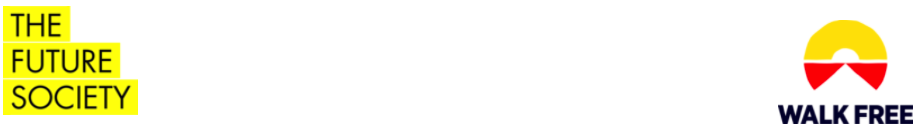

#*Project AIMS (AI against Modern Slavery)*
---






##💻 Note: You can run this notebook locally or on Google Colab following this [link](https://colab.research.google.com/drive/1VioulI7OnL36TOfTng5Q4Y3PLuRYcp5S#scrollTo=I4A4ug8eYmTl).


#  MSA incidents remediation 
## Did the company explain the corrective steps it has taken (or would take) in response to modern slavery incidents in its own operations and/or supply chain?
 
This task aims to find out if the company explains one or more steps it has taken or would take against the modern slavery incidents in their operations or in their supply chain. The Snorkel framework is applied to label the dataset by performing weak supervision.
Should a company find instances of modern slavery in its own operations and/or supply chain, the company has a responsibility to respect the human rights of those affected and should take steps to investigate and “provide for, or cooperate in their remediation through legitimate processes” (UN Guiding Principles). This can include taking collaborative approaches, such as working with the supplier to tackle the problem through corrective action plans or more punitive action, such as cancelling contracts with the supplier. Working with suppliers will help prevent such instances from occurring in the future and reinforce respect for human rights throughout the supply chain. However, remediation policies can be in place regardless of whether incidents took place in the operation of the company or in/ its supply chain or not.
 
### Labelled dataset
 
This metric had multiple options. If the company specifies that senior management will be informed if instances of modern slavery have been identified, the annotators selected 'Senior management' labels. If the company supports the supplier to respond to instances of modern slavery, the annotators select the 'Corrective action plan' label. If the company identifies punitive action by cancelling suppliers’ contracts, the annotators select the 'Cancel contracts' label. For all of those, the annotators added more information in the Comments section. For this task, if the statement included at least one of those labels, the statement was labelled with the value ‘Yes/1’.
 
If no such information exists in the statement, the annotators selected ‘No’ as a label. If the business indicates it is developing a remediation policy or planning to implement one in the future, the annotators selected 'In Development' and again provided details in the Comment. Both statements labelled ‘In development’ and ‘No’ were combined under the label ‘No/0’, for the purpose of this exercise.
 
For more information about this metric, please refer to  [WikiRate’s Research on MSA incidents remediation (revised) metric ](https://wikirate.org/Walk_Free_Foundation+MSA_incidents_remediation_revised) or [Home Office Guidance, pp. 34 and 37.](https://www.gov.uk/government/uploads/system/uploads/attachment_data/file/471996/Transparency_in_Supply_Chains_etc__A_practical_guide__final_.pdf).



In [ ]:
!pip install snorkel

In [ ]:
#from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/ProjectAIMS

/content/drive/.shortcut-targets-by-id/11tRyVLvElSSvedZDsiP76NndaI3wNyFb/Project AIMS


In [ ]:
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()
import pandas as pd
import re
import tqdm
import snorkel
import nltk 
from nltk import word_tokenize, pos_tag
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
labeled_dataset = pd.read_csv("labeled-dataset.csv", dtype=object,  index_col=0)
print('Number of available statements for incidents remediation metric is -> {:,}\n'.format( labeled_dataset.shape[0]))

Number of available statements for incidents remediation metric is -> 2,749



In [ ]:
metric ='Walk Free Foundation+MSA incidents remediation (revised)'
metric_binary = metric+' binary'

In [ ]:
# select relevant columns
columns = ['Answer ID', 'Answer Link', 'Metric', 'Company', 'Year', 'Value', 'Source', 'TEXT', metric]
data = labeled_dataset[columns]

# Remove unknown values from metric column
data = data.loc[(data[metric] != "Unknown") & (data[metric] != "unknown") & (data[metric] != " ") ,:]

# Remove empty values from metric column
data = data[data[metric].notna()]

# Remove rows with empty text cells
data = data[data['TEXT'].notna()]

#remove rows with duplicated text 
data = data.drop_duplicates(subset = 'TEXT')
original_dataset = data.copy()

print("After removing duplicates and empty values the shape is", data.shape)

After removing duplicates and empty values the shape is (1281, 9)


In [ ]:
data[metric].value_counts()

No                                                                                 616
Cancel contracts                                                                   191
Corrective action plan                                                             107
Corrective action plan, Cancel contracts                                           101
In Development                                                                      59
Senior management                                                                   35
Senior management, Cancel contracts                                                 21
Worker remediation                                                                  21
Corrective action plan, Worker remediation                                          13
Cancel contracts, In Development                                                    12
Worker remediation, Corrective action plan                                          10
Senior management, Corrective action plan  

In [ ]:
# define a binary metric
no_values = ['No',
            'In Development',
            'In Development, No']

In [ ]:
data[metric_binary] = [1 if value not in no_values else 0 for value in data[metric]]

In [ ]:
few_keywords = [" if a supplier is found to be", "providing remediation direct to the worker affected", "Backpayment", "support to prosecute", "informing senior management", " respond to instances of", "instigating corrective action plans", "cancelling the contracts of suppliers", "supports the supplier to respond", "corrective action plan", "punitive action", "developing a remediation policy", "planning to implement a remediation policy", "contract termination", "termination of the", "termination for failure", "will not deal with any supplier if", "reserves the right to terminate", "to terminate", "terminate relationship", "cessation of", "Cease", "Curtailment", "knowingly involved ", "cancel contracts", "cancel contract", "remedial action", "appropriate steps to", "continuously improve our processes to fight", "we require evidence", "action plans", "remedy", "repayment"]


In [ ]:
def get_keyword_lemmas(keywords_list):
    """
    Given a list of keyword combinations, extract lemmas from them.
    :param keywords_list: provided list of keywords describing a particular metric.
    """
    keywords_lemmas = list()
    for doc in nlp.pipe(keywords_list):
        keyword_lemma = [t.lemma_ for t in doc if (not t.is_punct) and (not t.is_stop) and (not t.is_space) ]
        keyword_lemma = ' '.join(keyword_lemma)
        keywords_lemmas.append( keyword_lemma)

    keywords_lemmas = set(keywords_lemmas)

    return keywords_lemmas


In [ ]:
few_keywords_lemmas = get_keyword_lemmas(few_keywords)

In [ ]:
few_keywords_lemmas

{'action plan',
 'appropriate step',
 'backpayment',
 'cancel contract',
 'cancel contract supplier',
 'cease',
 'cessation',
 'continuously improve process fight',
 'contract termination',
 'corrective action plan',
 'curtailment',
 'deal supplier',
 'develop remediation policy',
 'inform senior management',
 'instigate corrective action plan',
 'knowingly involve',
 'plan implement remediation policy',
 'provide remediation direct worker affect',
 'punitive action',
 'remedial action',
 'remedy',
 'repayment',
 'require evidence',
 'reserve right terminate',
 'respond instance',
 'supplier find',
 'support prosecute',
 'support supplier respond',
 'terminate',
 'terminate relationship',
 'termination',
 'termination failure'}

In [ ]:
def custom_sentencizer(doc):
    """
        Create a list of custom rules in order to differentiate the beginning and the end of a sentence
        :param doc: doc that needs to be be splitted into sentences
        :return: doc
    """
    
    for i, token in enumerate(doc[:-2]):
        if token.is_digit and str(doc[i+1]) == '.':      # Ex: 1. 2. 3.
            doc[i+2].is_sent_start= True
        if token.is_alpha and str(doc[i+1]) == ')':     # Ex: a) b) c)
            doc[i+2].is_sent_start= True
        if token.text == "-":
            doc[i].is_sent_start=False
        if token.text == ":":
            doc[i + 1].is_sent_start=True
        if token.text == "’s":                           # Ex: Company's 
            doc[i].is_sent_start=False
        if str(doc[i + 1]) == ":":
            doc[i + 2].is_sent_start=True
        if str(doc[i + 1]) == ";":
            doc[i + 2].is_sent_start=True
        if token.text in ['Mr.', 'Dr.']:
            doc[i + 2].is_sent_start=False
    return doc

nlp.add_pipe(custom_sentencizer, before="parser")

In [ ]:
def tense(sentence):
    text = word_tokenize(sentence)
    tagged = pos_tag(text)

    tense = {}
    tense["future"] = len([word for word in tagged if word[1] == "MD"])
    tense["present"] = len([word for word in tagged if word[1] in ["VBP", "VBZ","VBG"]])
    tense["past"] = len([word for word in tagged if word[1] in ["VBD", "VBN"]]) 

    if max(tense, key=tense.get) == 0:
        return 'present'
    else:
        return max(tense, key=tense.get)




In [ ]:
def get_sentences_w_keywords(doc, few_keywords_lemmas, tokens_at_a_time=10, steps=3):
    """
    Extract sentences where keyword lemmas can be found.
    :param doc: tokenized text using a spacy parser model
    :param few_keywords_lemmas: a set of lemmatised keywords to use for searching sentences.
    :param tokens_at_a_time: Window size in tokens in which keywords are searched at ta time, the default is 10
    :param steps: how many tokens to move the window forward, the default is 3

    """
    
    elements_set = list()
    
    doc_len = len(doc)
    
    for kw in few_keywords_lemmas:
        dict_elements = dict()

        for idx in range(0, doc_len, steps):
            # print(idx)
            span = doc[idx:idx+tokens_at_a_time]
            span_lemmas = ' '.join([t.lemma_ for t in span if (not t.is_punct) and (not t.is_stop) and (not t.is_space)])
            if kw in span_lemmas:

                dict_elements = dict()

                start_index = doc.text.index(span.sent.text)
                end_index = start_index + len(span.sent.text)-1
                dict_elements['element'] = kw
                dict_elements['sentence'] = span.sent.text.replace('\n', '') # remove new line tokens from sentences.
                dict_elements['span'] = ':'.join([str(start_index), str(end_index)])
                dict_elements['tense'] = tense_is = tense(span.sent.text)

                elements_set.append(dict_elements)

                
    return elements_set

def get_unique_sentences(dictionaries_list):
    unique_dicts = list({v['sentence']:v for v in dictionaries_list}.values())
    return unique_dicts
        

In [ ]:
data = original_dataset

In [ ]:
len(original_dataset)

1281

In [ ]:
%%time
extractions = [get_sentences_w_keywords(doc, few_keywords_lemmas) for doc in tqdm.tqdm(nlp.pipe(data['TEXT'],batch_size=100, disable=["tagger", "ner", "textcat"]))]
extractions = [get_unique_sentences(dictionaries_list) for dictionaries_list in extractions]
data['extractions'] = extractions

1281it [06:31,  3.27it/s]

CPU times: user 6min 26s, sys: 4.39 s, total: 6min 30s
Wall time: 6min 31s


In [ ]:
# with efficient implementation


In [ ]:
from snorkel.labeling import labeling_function
from snorkel.labeling.model import LabelModel
from snorkel.labeling import LabelingFunction
from snorkel.labeling import PandasLFApplier
from snorkel.labeling import LFAnalysis
from snorkel.labeling.model import MajorityLabelVoter

# For clarity, we define constants to represent the class labels for yes, no, and abstaining.
ABSTAIN = -1
NO = 0
YES = 1

In [ ]:
@labeling_function()
def find_keyword_elements(x):
    """
    If no elements were found using the keywords then return NO, otherwise YES.
    """
    if x['extractions'] == []:
        return NO
    else:
        return YES


In [ ]:
lfs = [find_keyword_elements]

applier = PandasLFApplier(lfs=lfs)
L_test = applier.apply(df=data)

coverage_approval_metric = (L_test == YES).mean(axis=0)
print(coverage_approval_metric)
print(LFAnalysis(L=L_test, lfs=lfs).lf_summary())


100%|██████████| 1281/1281 [00:00<00:00, 40113.36it/s]

[0.44808743]
                       j Polarity  Coverage  Overlaps  Conflicts
find_keyword_elements  0   [0, 1]       1.0       0.0        0.0


In [ ]:
label_model = LabelModel()
majority_model = MajorityLabelVoter()
final_labels = majority_model.predict(L=L_test)

In [ ]:
data.columns

Index(['Answer ID', 'Answer Link', 'Metric', 'Company', 'Year', 'Value',
       'Source', 'TEXT',
       'Walk Free Foundation+MSA incidents remediation (revised)',
       'extractions'],
      dtype='object')

In [ ]:
data[metric]

0        Worker remediation, Corrective action plan, Ca...
18                                  Corrective action plan
33                Corrective action plan, Cancel contracts
52              Corrective action plan, Worker remediation
66                                       Senior management
                               ...                        
30042                                                   No
30060                                                   No
30114             Corrective action plan, Cancel contracts
30132                                     Cancel contracts
30150                                                   No
Name: Walk Free Foundation+MSA incidents remediation (revised), Length: 1281, dtype: object

## Results


Evaluation of the rule-based model


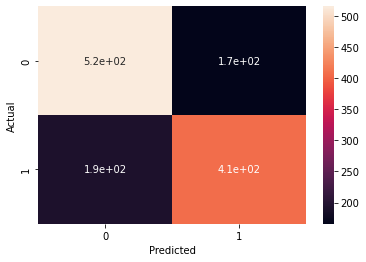

Confusion Matrix:
 [[515 166]
 [192 408]]
Accuracy Score: 0.7205308352849337
Precision Score: 0.7201730340395667
Recall Score: 0.7205308352849337
F1 Score: 0.7200537088714816


In [ ]:
y_true_str = data[metric_binary].tolist()
y_hat = final_labels
y_true =  list(map(int, y_true_str))


from utils import evaluation_rb
evaluation_rb.main(y_true, y_hat)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_true, y_pred=y_hat))

              precision    recall  f1-score   support

           0       0.73      0.76      0.74       681
           1       0.71      0.68      0.70       600

    accuracy                           0.72      1281
   macro avg       0.72      0.72      0.72      1281
weighted avg       0.72      0.72      0.72      1281



In [ ]:
data[metric+' predicted'] = final_labels

In [ ]:
data.to_csv('data/incidents-remediation-predicted.csv')

# Testing with a sample


In [ ]:
data_sample = data.sample(10).reset_index(drop=True)

In [ ]:

extractions = [get_sentences_w_keywords(doc, few_keywords_lemmas) for doc in tqdm.tqdm(nlp.pipe(data_sample['TEXT'],,batch_size=100))]
extractions = [get_unique_sentences(dictionaries_list) for dictionaries_list in extractions]
data_sample['extractions'] = extractions

In [ ]:
data_sample['extractions']

In [ ]:
data_sample.head()